# BASELINE MODEL

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy as np
import scipy
import sys
from scipy import io
import math
import random
import keras
from sklearn import preprocessing
from glob import glob
import tqdm

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# GLOBALS

In [3]:
POET_DIR = "D:/data/POETdataset/"
PATCHES_FILE = os.path.join(POET_DIR, "x.npy")
LABELS_FILE = os.path.join(POET_DIR, 'y.npy')
pascal_images = os.path.join(POET_DIR, 'PascalImages')
PATCH_SIZE = 32
HALF_PATCH = PATCH_SIZE//2
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
MAX_GAZE_POINTS = 3 # TEMPORARY
MIN_GAZE_POINTS = 3
VGG_NR_FEATURES = 512
user_index = 0 # TEMPORARY
BATCH_SIZE = 50
IMG_SIZE = 224

In [4]:
os.chdir(POET_DIR)

# DATA 

In [5]:
classes = [a.split("_")[1].split(".mat")[0] for a in glob("etData/*")]
idx2class = {i:c for i, c in enumerate(classes)}
class2idx = {c:i for i, c in enumerate(classes)}

In [21]:
learned_model = keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='max')
pp_func = keras.applications.resnet50.preprocess_input

features_extractor_model = keras.models.Sequential()
features_extractor_model.add(keras.layers.Lambda(pp_func,name='preprocessing',input_shape=(IMG_SIZE,IMG_SIZE,3)))
features_extractor_model.add(learned_model)


## We store the feature vectors for each image

In [7]:
classes

['aeroplane',
 'bicycle',
 'boat',
 'cat',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'sofa']

In [24]:
x = []
y = []
for i, cname in enumerate(tqdm.tqdm(classes)):
    print(cname)
    class_files = glob("PascalImages/%s*" %cname)
    files_loaded = [keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(file_, target_size=(IMG_SIZE, IMG_SIZE, 3)
                                          )
    ) 
                    for file_ in class_files
                   ]
    feature_vec = features_extractor_model.predict(np.array(files_loaded),verbose=1)
    x.append(feature_vec)
    y.append([class2idx[cname]]*len(class_files))
x = np.concatenate(x)
y = np.concatenate(y)
                                                           

  0%|                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

aeroplane


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [00:11<01:45, 11.70s/it]

bicycle


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [00:19<01:24, 10.53s/it]

boat


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [00:26<01:05,  9.37s/it]

cat


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [00:40<01:05, 10.87s/it]

cow


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [00:45<00:44,  8.97s/it]

diningtable


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [00:52<00:34,  8.59s/it]

dog


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [01:10<00:33, 11.25s/it]

horse


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [01:17<00:20, 10.05s/it]

motorbike


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [01:25<00:09,  9.41s/it]

sofa


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  8.59s/it]


In [25]:
x.shape

(6270, 2048)

In [28]:
y[0]

0

In [29]:
np.save('baselinemodel-images-features.npy',x)

In [30]:
np.save('baselinemodel-labels.npy',y)

(array([ 666.,  536.,  504., 1051.,  301.,  498., 1257.,  480.,  510.,
         467.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

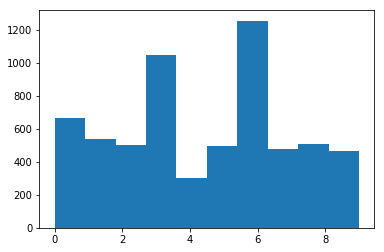

In [31]:
plt.hist(y)

In [32]:
X_img = np.zeros((len(x), IMG_SIZE, IMG_SIZE, 3))

In [33]:
from sklearn.preprocessing import OneHotEncoder

In [34]:
enc = OneHotEncoder()
y = y.reshape(-1,1)
enc.fit(y)
y_onehot = enc.transform(y)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [35]:
np.save('y.npy', y_onehot)

In [37]:
x.shape

(6270, 2048)

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x, y_onehot.todense(), test_size=0.1, stratify=y_onehot.todense())

# MODEL

In [42]:
model = keras.Sequential()
model.add(keras.layers.Dense(128, activation='relu', input_shape=(2048,)))
model.add(keras.layers.Dense(10, activation='softmax'))
optm = keras.optimizers.rmsprop(lr=0.00001)
model.compile(loss='categorical_crossentropy',
                optimizer=optm,
                metrics=['accuracy'],)

In [44]:
model.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_data=(X_test, y_test),    
    epochs=100
)

Train on 5643 samples, validate on 627 samples
Epoch 1/100
5643/5643 [==============================] - 1s 133us/step - loss: 0.6802 - acc: 0.8159 - val_loss: 1.0412 - val_acc: 0.7735
Epoch 2/100
5643/5643 [==============================] - 1s 133us/step - loss: 0.6439 - acc: 0.8258 - val_loss: 1.0256 - val_acc: 0.7735
Epoch 3/100
5643/5643 [==============================] - 1s 130us/step - loss: 0.6127 - acc: 0.8348 - val_loss: 1.0094 - val_acc: 0.7687
Epoch 4/100
5643/5643 [==============================] - 1s 133us/step - loss: 0.5832 - acc: 0.8377 - val_loss: 0.9931 - val_acc: 0.7703
Epoch 5/100
5643/5643 [==============================] - 1s 130us/step - loss: 0.5555 - acc: 0.8469 - val_loss: 0.9875 - val_acc: 0.7703
Epoch 6/100
5643/5643 [==============================] - 1s 130us/step - loss: 0.5307 - acc: 0.8556 - val_loss: 0.9694 - val_acc: 0.7815
Epoch 7/100
5643/5643 [==============================] - 1s 133us/step - loss: 0.5069 - acc: 0.8596 - val_loss: 0.9738 - val_acc: 0